In [50]:
%matplotlib inline
%config InlineBackend.figure_format = "retina"
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
from torch import nn, optim
from torchvision import datasets, transforms, models
import torch.nn.functional as F
from torch.autograd import Variable
import time
from torch.utils.data.sampler import SubsetRandomSampler
from collections import OrderedDict
# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device = torch.device("cpu")
print(device)

cpu


In [30]:
# Set up place to download pretrained model from internet
# import os
# os.environ['TORCH_HOME'] = '../models/pretrained/'

In [51]:
# data_dir = '../data/processed'
data_dir = '../data/'
batch_size = 16
valid_size = 0.2
num_workers = 4

#Define a transform
train_transforms = transforms.Compose([
    transforms.RandomRotation(30),
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406),(0.229, 0.224, 0.225))
    ])

test_transforms = transforms.Compose([
    transforms.Resize(255),
    transforms.CenterCrop(224),
    transforms.ToTensor()
])

train_data = datasets.ImageFolder(data_dir + "/raw", transform=train_transforms)

num_train = len(train_data)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(valid_size*num_train))
train_idx, valid_idx = indices[split:], indices[:split]

train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

print("Loading data ....")
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, sampler=train_sampler, num_workers=num_workers)
valid_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, sampler=valid_sampler, num_workers=num_workers)

#For loading test data
# test_data = datasets.ImageFolder(data_dir + "/test", transform=test_transforms)
# testloader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, num_workers=num_workers)
print("Done!")

Loading data ....
Done!


In [52]:
data_path = "../data/raw/"
dataframe = pd.read_csv(data_path+'annotation.csv')
dataframe.head()
print("Annotation data: ",len(dataframe))
height = torch.from_numpy(np.array(dataframe.height.values))
weight = torch.from_numpy(np.array(dataframe.weight.values))
BMI = torch.from_numpy(np.array(dataframe.BMI.values))

Annotation data:  1026


In [53]:
model = models.resnet50(pretrained=True)

In [58]:
for param in model.parameters():
  param.requires_grad = False

from collections import OrderedDict

fc = nn.Sequential(OrderedDict([
    # ("average", nn.AvgPool1d()),
    ("fc1", nn.Linear(2048, 1024)),
    ("relu1", nn.ReLU()),
    ("fc2", nn.Linear(1024, 512)),
    ("relu2", nn.ReLU()),
    ("output", nn.Linear(512, 1)),
]))

model.fc = fc

#Move model to GPU
model.to(device);

In [59]:
base_learning_rate = 1e-5
epochs = 2
weight_decay = 0.0005
gamma = 0.001
power = 0.75
criterion = nn.SmoothL1Loss().to(device)
train_losses, valid_losses = [], []
steps = 0

In [61]:
#training model
for epoch in range(epochs):
    running_loss = 0
    learning_rate = base_learning_rate*(1+gamma*epoch)**(-power)
    optimizer = optim.SGD(model.fc.parameters(), lr=learning_rate, weight_decay=weight_decay, momentum=0.9)
    
    for images, values in trainloader:
        # Reset optimizer
        optimizer.zero_grad()

        #Send data to GPU
        images = images.to(device)
        values = values.type(torch.FloatTensor).to(device)

        #Training model
        predictions = model(images)
        loss = criterion(predictions, values)
        
        #Backpropagation
        loss.backward()

        #Update weight
        optimizer.step()
    
        #Calculate running loss
        running_loss += loss.item()
    else:
        validating_loss = 0

        #Turn off the gradient descent, save memory and computations
        with torch.no_grad():
            for images, values in valid_loader:

                #Move data to GPU
                images = images.to(device)
                values = values.type(torch.FloatTensor).to(device)

                #Run model
                predictions = model(images)
                loss = criterion(predictions, values)
                validating_loss += loss.item()
    
        train_losses.append(running_loss/len(train_loader))
        valid_losses.append(validating_loss/len(valid_loader))

        print(
            "Epoch: {}/{}..".format(epoch+1, epochs),
            "Training loss: {:.3f}".format(running_loss/len(train_loader)),
            "Validating loss: {:.3f}".format(validating_loss/len(valid_loader))
            )

Epoch: 1/2.. Training loss: 0.006 Validating loss: 0.004
Epoch: 2/2.. Training loss: 0.005 Validating loss: 0.003


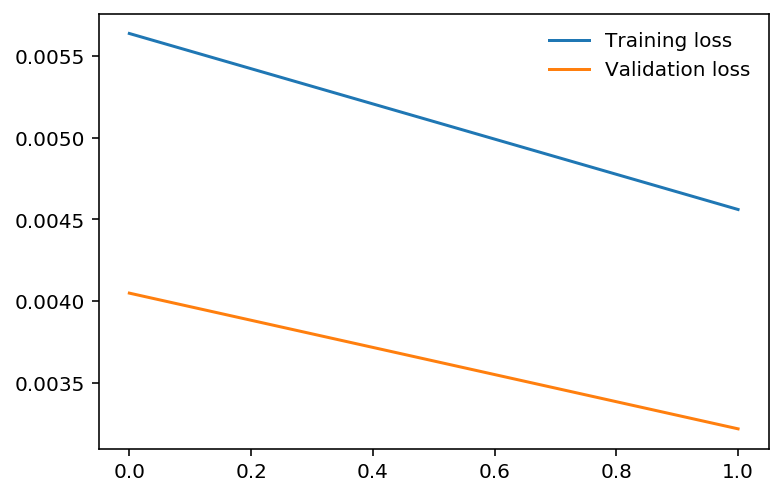

In [62]:
plt.plot(train_losses, label="Training loss")
plt.plot(valid_losses, label="Validation loss")
plt.legend(frameon=False);